# **3. Data Preparation**

In this section I'll create methods to preprocess the training data available in `artifacts/train.csv` (at root, after running data_ingestion.py).

Based on the `2. Exploratory Data Analysis`, I have to do the following transfomations in the data:

1. **Tokenize text**

2. **Calculate reading ease score**

3. **Remove irrelevant information (can be anything that is not a letter)**

4. **Calculate lexical diversity**

5. **Count typos**

6. **Remove typos**

7. **Remove stopwords**

8. **Remove nouns**

9. **Texts to vectors**


**Obs:**
* Before any text manipulation, the text need to be tokenize. That's why has `1.`;

* For better usage, typos must be removed before usage. That's why has `6.`;

* Should be better to correct the typos, but abbreviations can be get as typos, so thats not a good idea;

* I need a way to tranform the texts into vectors. And the way I'll handle it is with word2vec. That's why has `9.`;

## **Importing libraries**

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import probplot

# text manipulation
import spacy
from spacy.tokens import Doc

# text typos detection
from symspellpy import SymSpell, Verbosity
import importlib.resources

# text statistics
import textstat

# scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

## **Setting up libraries**

In [2]:
# setting up spacy and disabling unused pipeline components
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner', 'lemmatizer', 'textcat', 'custom'])

In [3]:
# setting up SymSpell to typo count
sym_spell = SymSpell(max_dictionary_edit_distance=1, prefix_length=7)

with importlib.resources.open_text('symspellpy', 'frequency_dictionary_en_82_765.txt') as file:
    dictionary_path = file.name
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

## **Loading training dataset**

In [4]:
data = pd.read_csv('../artifacts/train.csv')

In [5]:
# show first rows
data.head()

,text,generated
0,In this essay I will talk about if the use of ...,0
1,The importance of self-care should never be un...,1
2,"Do you think this ""face"" was created by aliens...",0
3,\nThe potential impact of the use of social me...,1
4,Many people believe that self-esteem comes fro...,0


## **Data Transformation**

I'll make all the required tranformation into an unique function even to obtain better performance.

In [6]:
def prepare_model_data(data):
    '''
    Helper function to prepare data to the ML model. 
    This function applies:
        * text tokenization
        * irrelevant information removing
        * typos removing
        * stopwords removing
        * nouns removing
        * word2vec with spacy
        
    Also, this function calculate:
        * typos count
        * reading ease score
        * lexical diversity score

    Parameters
    ---
    * data: text data to prepare the data
    
    Returns
    ---
    * a numpy array with the columns: 300 size vector (representing the text), typos_count, reading_ease_score and lexical_deversity_score

    '''

    # tranfrom texts in spacy docs (wich applies tokenization)
    docs = [doc for doc in nlp.pipe(data)]

    text_vectors = []
    typos_counts = []
    reading_ease_scores = []
    lexical_diversity_scores = []

    def calculate_reading_ease_score(text):
        '''
        Helper function to calculate reading ease score.
        '''
        try:
            return textstat.flesch_reading_ease(text)
        except ZeroDivisionError:
            return 0.0
        
    def calculate_lexical_diversity_score(words_list):
        '''
        Helper function to calculate lexical diversity score from the words list.
        '''
        total_words_count = len(words_list)
        unique_words_count = len(set(words_list))

        if total_words_count == 0:
            return 0.0
        else:
            return unique_words_count / total_words_count

    for doc in docs:

        # reading ease score
        reading_ease_scores.append(calculate_reading_ease_score(doc.text))

        # count typos
        typos_count = 0

        nouns = []
        words = []
        spaces = []
        for token in doc:
            if not token.is_alpha: # ignore irrelevant information
                continue

            if token.is_stop: # ignore stopwords
                continue

            if token.pos_ in ['NOUN', 'PROPN']: # ignore nouns
                nouns.append(token.text.lower()) # consider nouns just to lexical diversity calculation
                continue

            # lookup for typo
            word = token.text.lower()
            suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=1) # lookup for typo

            # check if is a typo
            if not suggestions or not any(suggestion.term == word for suggestion in suggestions):
                typos_count += 1
                continue

            words.append(word)
            spaces.append(token.whitespace_)

        # add typos count
        typos_counts.append(typos_count)

        # lexical diversity
        lexical_diversity_scores.append(calculate_lexical_diversity_score(words + nouns))

        # create and add text vector to list
        clean_doc = Doc(vocab=nlp.vocab, words=words, spaces=spaces)
        text_vectors.append(clean_doc.vector)

    # return numpy array
    return np.column_stack([text_vectors, typos_counts, reading_ease_scores, lexical_diversity_scores])

In [7]:
# prepare the data
prepared_data = prepare_model_data(data.text)

In [8]:
print('Prepared data shape:', prepared_data.shape)

Prepared data shape: (23316, 303)


### **Applying Data Scaling**

My input data has the following structure:

* the first 300 data are related to the wor2vec representation of the text;

* after has typos_count;

* then reading_ease_scores;

* and finally lexical_diversity_scores.

My plan to apply scaling here is the following:

* for the text representation part, I'll use MinMaxScaler, because I'm just interested in cosine similarity (that way size doesn't matters);

* make a prob plot for the other 3 variables to see if them follows a normal distrbution (I already have an idea that reading_ease_score and lexical_diversity_score follows some kind of normal distribution), then, if they follow, I'll use StandardScaler.

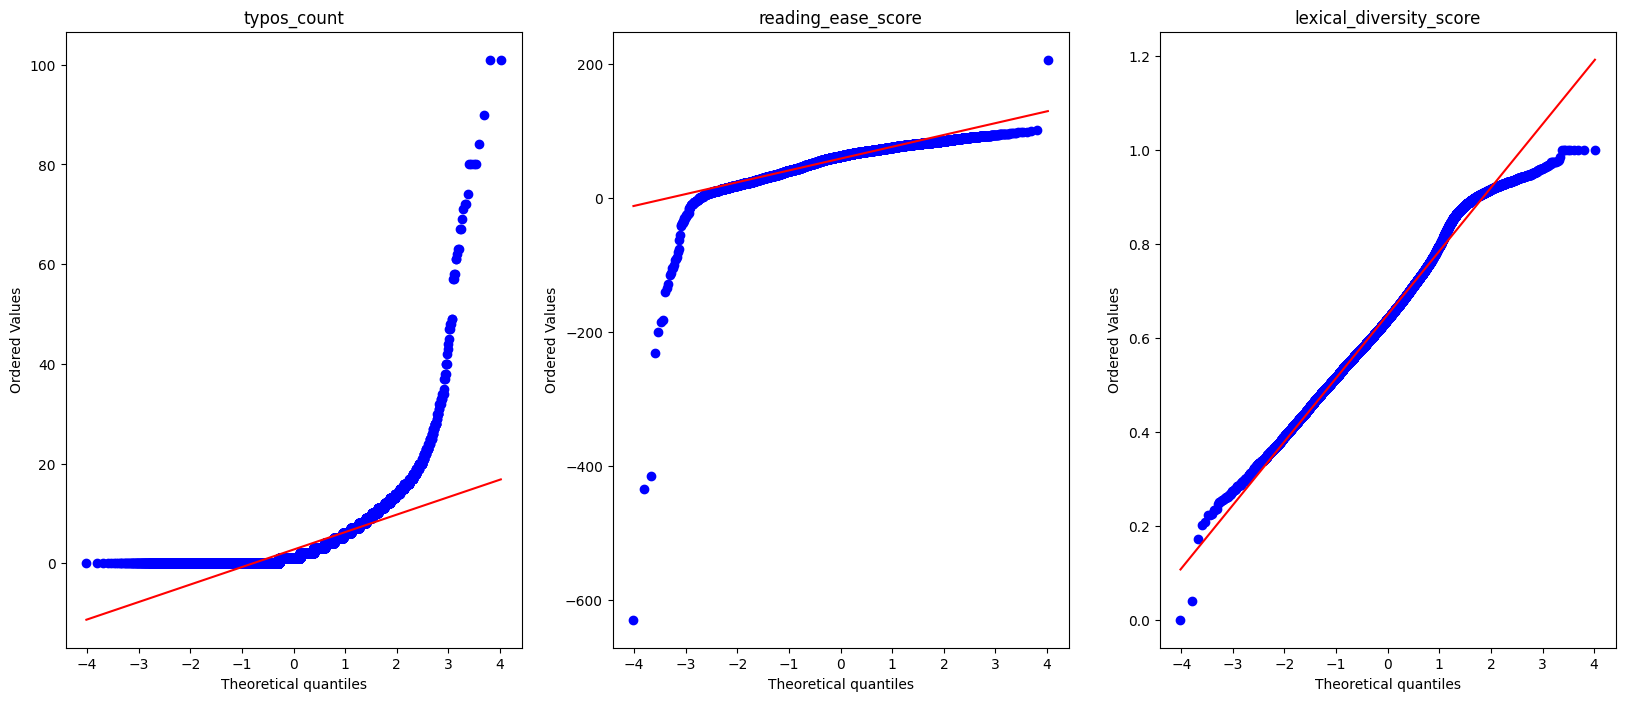

In [23]:
# create plot
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

# plot probplot
probplot(prepared_data[:, 300], dist='norm', plot=ax0)
probplot(prepared_data[:, 301], dist='norm', plot=ax1)
probplot(prepared_data[:, 302], dist='norm', plot=ax2)

# config plot
ax0.set_title('typos_count')
ax1.set_title('reading_ease_score')
ax2.set_title('lexical_diversity_score')

plt.show()

**Observations:**

* typos_count: doesn't fit the red line very well, it means thta it don't have a normal distribution. Because of that I'll use MinMaxScaler;

* reading_ease_score: great part fit well on the red line but some data fits completly out of red line, it was already observed in the previous section `2. Exploratory Data Analysis`. How it have some kind of normal distribution I'll use StandardScaler;

* lexical_diversity_score: great part fit well on the red line but some data fits a bit out of red line, it was already observed in the previous section `2. Exploratory Data Analysis`. How it have some kind of normal distribution I'll use StandardScaler.

In [24]:
prepared_data_scaled = prepared_data

# apply min max scaler in the word_2_vec vector and typos_count
min_max_scaler = MinMaxScaler()
prepared_data_scaled[:, :301] = min_max_scaler.fit_transform(prepared_data_scaled[:, :301])

# apply standard scaler in reading_ease_score and lexical_diversity_score
std_scaler = StandardScaler()
prepared_data_scaled[:, 301:] = std_scaler.fit_transform(prepared_data_scaled[:, 301:])

In [25]:
# show result
prepared_data_scaled

array([[ 0.35084143,  0.60440606,  0.33725433, ...,  0.        ,
        -0.13061205, -0.41628668],
       [ 0.36191152,  0.70181609,  0.24839216, ...,  0.        ,
        -0.7499107 ,  1.58900066],
       [ 0.22305228,  0.5453543 ,  0.39146353, ...,  0.01980198,
         1.11890489, -0.19919092],
       ...,
       [ 0.3559904 ,  0.77909745,  0.26653609, ...,  0.        ,
        -0.35940416, -1.73657365],
       [ 0.51917349,  0.81607923,  0.19464396, ...,  0.10891089,
         0.81783527,  1.1826067 ],
       [ 0.34433392,  0.69782946,  0.30366448, ...,  0.11881188,
         1.18754253,  0.02986794]])

In [26]:
# show result shape
prepared_data_scaled.shape

(23316, 303)